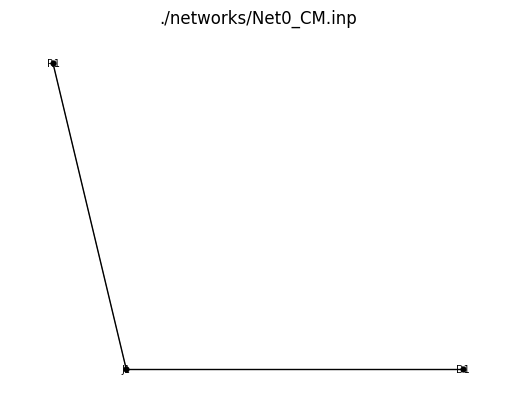

<Axes: title={'center': './networks/Net0_CM.inp'}>

In [1]:
import wntr
import wntr_quantum
import numpy as np

# Create a water network model
inp_file = './networks/Net0_CM.inp'
# inp_file = './networks/Net2LoopsDW.inp'
wn = wntr.network.WaterNetworkModel(inp_file)

# Graph the network
wntr.graphics.plot_network(wn, title=wn.name, node_labels=True)

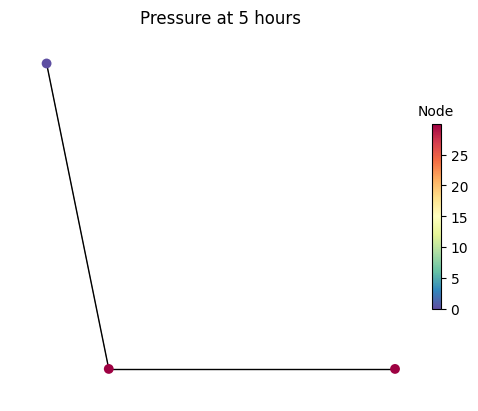

<Axes: title={'center': 'Pressure at 5 hours'}>

In [2]:
sim = wntr.sim.EpanetSimulator(wn)
results = sim.run_sim()
# Plot results on the network
pressure_at_5hr = results.node['pressure'].loc[0, :]
wntr.graphics.plot_network(wn, node_attribute=pressure_at_5hr, node_size=50,
                        title='Pressure at 5 hours', node_labels=False)

In [3]:
ref_pressure = results.node['pressure'].values[0][:2]
ref_rate = results.link['flowrate'].values[0]
ref_values = np.append(ref_rate, ref_pressure)
ref_values

array([ 0.05 ,  0.05 , 29.994, 29.988], dtype=float32)

# Run with QUBO solver

In [4]:
from wntr_quantum.sim.solvers.qubo_polynomial_solver import QuboPolynomialSolver
from qubops.solution_vector import SolutionVector_V2 as SolutionVector
from qubops.encodings import  RangedEfficientEncoding, PositiveQbitEncoding

nqbit = 7
step = (2./(2**nqbit-1))
flow_encoding = PositiveQbitEncoding(nqbit=nqbit, step=step, offset=+0.0, var_base_name="x")

nqbit = 9
step = (50/(2**nqbit-1))
head_encoding = PositiveQbitEncoding(nqbit=nqbit, step=step, offset=+75.0, var_base_name="x")

In [5]:
from wntr_quantum.design.qubo_pipe_diam import QUBODesignPipeDiameter 
pipe_diameters = [250, 500, 1000]
designer = QUBODesignPipeDiameter(wn, flow_encoding, head_encoding, pipe_diameters, head_lower_bound=80)

In [6]:
designer.verify_encoding()

Head Encoding : 75.000000 => 125.000000 (res: 0.097847)
Flow Encoding : -2.000000 => -0.000000 | 0.000000 => 2.000000 (res: 0.015748)


In [7]:
designer.create_index_mapping()
designer.matrices = designer.initialize_matrices()
designer.classical_solution([0,1,0,0,1,0], convert_to_si=False)

/home/nico/QuantumApplicationLab/QuantumNewtonRaphson/quantum_newton_raphson/utils.py:74: SparseEfficiencyWarning: spsolve requires A be CSC or CSR matrix format
  warn("spsolve requires A be CSC or CSR matrix format", SparseEfficiencyWarning)


(array([ 1.766,  1.766, 97.666, 96.906]),
 array([ 1.764,  1.764, 97.701, 96.918]),
 [1,
  1,
  [0, 0, 0, 0, 1, 1, 1],
  [0, 0, 0, 0, 1, 1, 1],
  [0, 0, 0, 1, 0, 1, 1, 1, 0],
  [0, 0, 0, 0, 0, 1, 1, 1, 0]],
 True)

In [8]:
designer.enumerates_classical_solutions(convert_to_si=False)

price 	 diameters 	 variables
0.16907910944516957 [250. 250.] [ 1.766  1.766 67.877 37.329]
0.25361866416775436 [250. 500.] [ 1.766  1.766 67.877 67.118]
0.42269777361292393 [ 250. 1000.] [ 1.766  1.766 67.877 67.858]
0.25361866416775436 [500. 250.] [ 1.766  1.766 97.666 67.118]
0.33815821889033915 [500. 500.] [ 1.766  1.766 97.666 96.906]
0.5072373283355087 [ 500. 1000.] [ 1.766  1.766 97.666 97.647]
0.42269777361292393 [1000.  250.] [ 1.766  1.766 98.406 67.858]
0.5072373283355087 [1000.  500.] [ 1.766  1.766 98.406 97.647]
0.6763164377806783 [1000. 1000.] [ 1.766  1.766 98.406 98.387]


In [9]:
designer.convert_solution_from_si(ref_values)

array([ 1.766,  1.766, 98.406, 98.387], dtype=float32)

In [10]:
from wntr_quantum.sampler.simulated_annealing import SimulatedAnnealing
sampler = SimulatedAnnealing()

In [11]:
from qubops.qubops_mixed_vars import QUBOPS_MIXED
import sparse

designer.qubo = QUBOPS_MIXED(designer.mixed_solution_vector, {"sampler": sampler})
matrices = tuple(sparse.COO(m) for m in designer.matrices)
designer.qubo.qubo_dict = designer.qubo.create_bqm(matrices, strength=0)

In [18]:
from dwave.samplers import SimulatedAnnealingSampler
options = {'sampler': SimulatedAnnealingSampler()}
status = designer.solve(strength=1E8, num_reads=5000,  options=options)

/home/nico/miniconda3/envs/vitens_wntr_1/lib/python3.9/site-packages/dimod/binary/binary_quadratic_model.py:759: UserWarning: For constraints with fractional coefficients, multiply both sides of the inequality by an appropriate factor of ten to attain or approximate integer coefficients. 
  warnings.warn("For constraints with fractional coefficients, "


KeyboardInterrupt: 

In [ ]:
designer.total_pice

0.6763164377806783

In [ ]:
designer.optimal_diameters

array([1000., 1000.])

In [ ]:
designer.qubo.qubo_dict.num_variables

438

(array([1.420e+02, 6.990e+02, 1.333e+03, 1.408e+03, 9.230e+02, 3.790e+02, 9.000e+01, 2.300e+01, 2.000e+00, 1.000e+00]),
 array([1.00e+08, 3.10e+08, 5.20e+08, 7.30e+08, 9.40e+08, 1.15e+09, 1.36e+09, 1.57e+09, 1.78e+09, 1.99e+09, 2.20e+09]),
 <BarContainer object of 10 artists>)

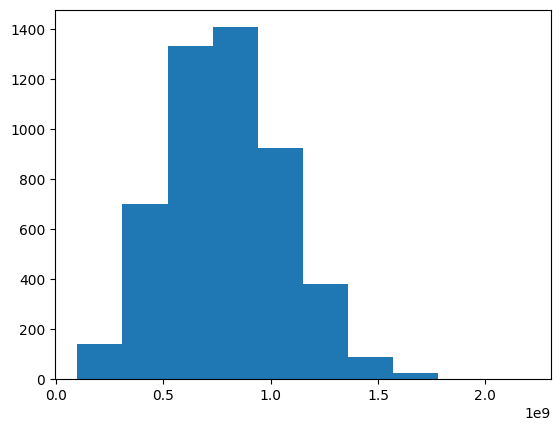

In [ ]:
import matplotlib.pyplot as plt
plt.hist(designer.sampleset.data_vectors['energy'])

In [ ]:
x = designer.sampleset

In [ ]:
x.record[1]

([1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0,

In [ ]:
for i in range(100):
    s = designer.qubo.decode_solution(x.record[i][0])
    print(s[3])

[1, 1, 1, 1, 1, 1]
[1, 0, 1, 1, 0, 1]
[1, 1, 0, 1, 1, 0]
[1, 1, 0, 0, 1, 1]
[1, 0, 1, 0, 1, 0]
[1, 1, 0, 1, 0, 0]
[0, 1, 1, 0, 0, 1]
[1, 1, 0, 0, 0, 1]
[1, 1, 0, 0, 0, 1]
[0, 0, 1, 1, 1, 0]
[0, 1, 0, 1, 0, 0]
[0, 1, 0, 1, 0, 0]
[1, 1, 0, 0, 1, 1]
[0, 1, 1, 0, 1, 1]
[1, 1, 1, 0, 1, 1]
[0, 1, 1, 0, 1, 0]
[1, 1, 0, 1, 1, 0]
[1, 1, 0, 1, 0, 0]
[1, 0, 0, 0, 1, 0]
[1, 0, 1, 0, 0, 1]
[1, 0, 1, 1, 1, 1]
[0, 1, 1, 0, 1, 0]
[1, 1, 1, 0, 1, 0]
[1, 0, 1, 0, 0, 1]
[1, 0, 1, 1, 0, 0]
[0, 0, 1, 0, 1, 0]
[1, 1, 0, 0, 0, 1]
[1, 1, 0, 0, 1, 1]
[1, 1, 0, 1, 0, 1]
[1, 1, 0, 0, 1, 1]
[1, 0, 1, 1, 0, 1]
[0, 1, 1, 0, 1, 1]
[1, 1, 0, 0, 0, 1]
[1, 1, 0, 0, 0, 1]
[1, 0, 1, 1, 0, 0]
[0, 0, 1, 0, 1, 1]
[1, 0, 1, 1, 0, 0]
[1, 1, 0, 1, 0, 0]
[0, 1, 1, 1, 1, 0]
[1, 0, 1, 0, 1, 0]
[0, 1, 1, 0, 0, 1]
[1, 0, 1, 0, 1, 1]
[1, 0, 1, 0, 1, 1]
[1, 0, 1, 0, 1, 1]
[0, 1, 1, 1, 0, 1]
[0, 0, 1, 1, 0, 1]
[0, 1, 1, 1, 0, 0]
[0, 0, 1, 0, 1, 0]
[0, 0, 1, 1, 1, 0]
[1, 1, 1, 0, 0, 1]
[1, 1, 0, 1, 1, 0]
[1, 0, 0, 0, 1, 1]
[1, 0, 1, 1,

In [ ]:
x.lowest().record[0][0]

array([1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0,
       0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1,
       1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 